In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob

In [3]:
import lanelines
import roadplane

from compgraph import CompGraph, CompGraphRunner
import nxpd
nxpd.nxpdParams['show'] = 'ipynb'

## Initialization

In [4]:
test_images = [lanelines.open_image(f) for f in glob('test_images/*.jpg')]

In [5]:
CANVAS_SZ = (600, 800)

warp_src = np.load('serialize/planepoints.npy')
warp_dst = lanelines.get_rectangle_corners_in_image(CANVAS_SZ, offset_x=100, offset_y=20)

M = cv2.getPerspectiveTransform(warp_src, warp_dst)
Minv = cv2.getPerspectiveTransform(warp_dst, warp_src)

In [6]:
warped_images = [cv2.warpPerspective(im, M, CANVAS_SZ, flags=cv2.INTER_LINEAR) for im in test_images]

## Functions

In [7]:
def convert_to_HLS(im):
    return cv2.cvtColor(im, cv2.COLOR_RGB2HLS)


def weighted_sum_images(images, weights):
    
    assert len(weights) == len(images)
    
    nonzero_indices = np.nonzero(weights)[0]
    if len(nonzero_indices) < 2:
        raise Exception('At least 2 non-zero weights are required')
    
    first, second = nonzero_indices[:2]
    res = cv2.addWeighted(images[first], weights[first], images[second], weights[second], 0)
    
    if len(nonzero_indices) == 2:
        return res
    
    for i in nonzero_indices[2:]:
        res = cv2.addWeighted(res, 1., images[i], weights[i], 0)
        
    return res


def bitwise_or(images):
    
    assert len(images) > 0
    
    if len(images) == 1:
        return images[0]
    
    res = cv2.bitwise_or(images[0], images[1])
    if len(images) == 2:
        return res
    
    for im in images[2:]:
        res = cv2.bitwise_or(res, im)
        
    return res
    
    
def weighted_HLS(H, L, S, weights):
    return weighted_sum_images([H, L, S], weights)


def add_contrast(im, gain):
    gained = gain * im
    return lanelines.scale_image_255(gained)


def sobel_combo(im):
    
    sobelx = lanelines.sobel_x(im)
    sobely = lanelines.sobel_y(im)
    
    magnitude = lanelines.sobel_magnitude(sobelx, sobely)
    direction = lanelines.sobel_direction(sobelx, sobely)
    
    return lanelines.scale_image_255(magnitude), lanelines.scale_image_255(direction)


def scaled_sobel_x(im):
    return lanelines.scale_image_255( lanelines.sobel_x(im) )


def morphological_close(im, kernel=(3, 3)):
    return cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)


def get_hls_channels(im):
    
    hls = convert_to_HLS(im)
    
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    return H, L, S

def gather_thresholded_images(*images):
    return images
    

## Pipeline

In [8]:
func_dict = {
    'get_HLS': get_hls_channels,
    'weighted_HLS_sum': weighted_HLS,
    'threshold_S': lanelines.mask_threashold_range,
    'threshold_H': lanelines.mask_threashold_range,
    'threshold_wHLS': lanelines.mask_threashold_range,
    'apply_sobel_x_to_S': scaled_sobel_x,
    'threshold_S_sobel_x': lanelines.mask_threashold_range,
    'median_blur_tssx': cv2.medianBlur,
    'close_thresholded_S': morphological_close,
    'gather_thresholded_images': gather_thresholded_images,
    'combine_thresholds_weighted': weighted_sum_images,
    
}

func_io = {
    'get_HLS': ('image', ('H', 'L', 'S')),
    'weighted_HLS_sum': (('H', 'L', 'S', 'HLS_weights'), 'weighted_HLS'),
    'threshold_S': (('S', 'S_from', 'S_to'), 'thresholded_S'),
    'threshold_H': (('H', 'H_from', 'H_to'), 'thresholded_H'),
    'threshold_wHLS': (('weighted_HLS', 'wHLS_from', 'wHLS_to'), 'thresholded_wHLS'),
    'apply_sobel_x_to_S': ('S', 'S_sobel_x'),
    'threshold_S_sobel_x': (('S_sobel_x', 'S_sobel_x_from', 'S_sobel_x_to'), 'thresholded_S_sobel_x'),
    'median_blur_tssx': (('thresholded_S_sobel_x', 'tssx_median_kernel'), 'tssx_median'),
    'close_thresholded_S': (('thresholded_S', 'close_kernel_for_tS'), 'ts_closed'),
    'gather_thresholded_images': (
        ('tssx_median', 'ts_closed', 'thresholded_H'), 
        'thresholded_images'
    ),
    'combine_thresholds_weighted': (('thresholded_images', 'thresholded_images_weights'), 'mega_image'),
}

cg = CompGraph(func_dict, func_io)

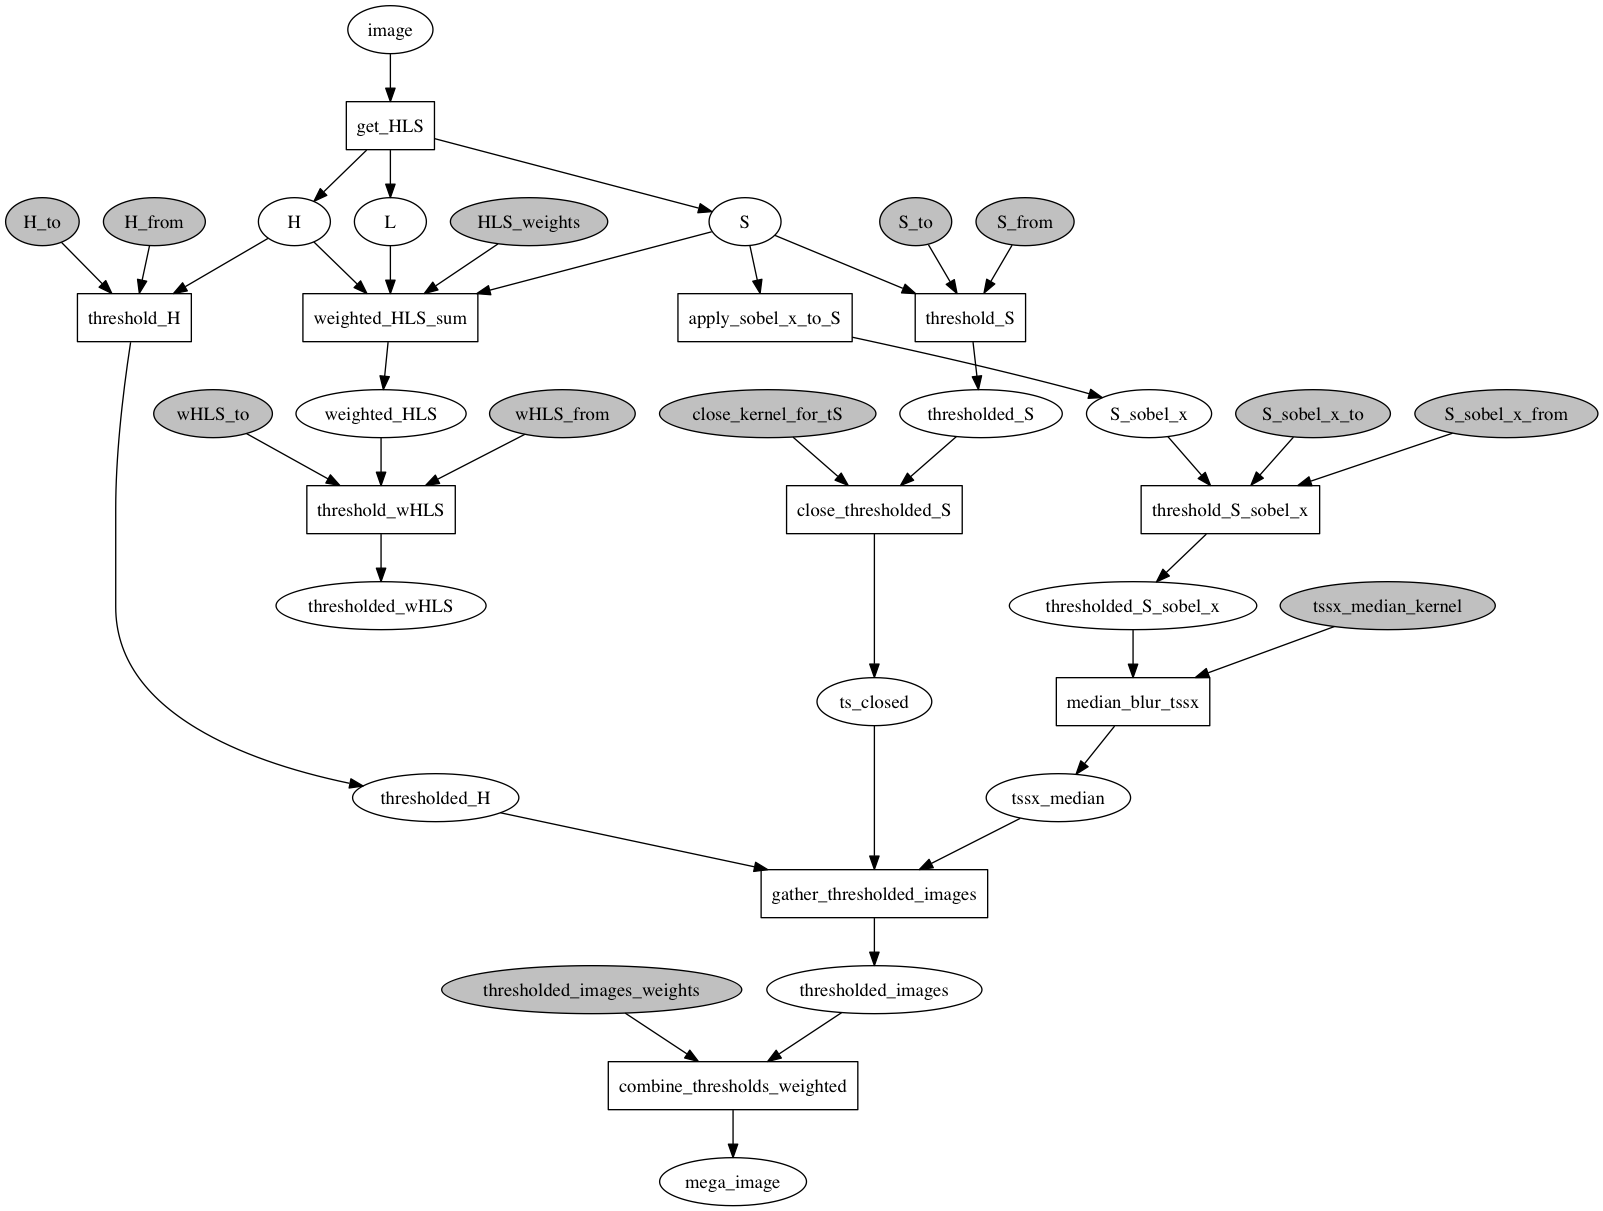

In [9]:
params = {
    'HLS_weights': [0, 0.7, 1.],
    'S_from': 180,
    'S_to': 250,
    'H_from': 90,
    'H_to': 100,
    'wHLS_from': 220,
    'wHLS_to': 250,
    'S_sobel_x_from': 20, # 20
    'S_sobel_x_to': 100, #60
    'tssx_median_kernel': 11,
    'close_kernel_for_tS': (3, 3),
    'thresholded_images_weights': [
#        3.,  # t_wHLS
        11.,  # t_ssx_median
        7., # ts_closed
        5.  # t_H
    ]
}

runner = CompGraphRunner(cg, frozen_tokens=params)
runner.run(image=warped_images[1])

nxpd.draw(runner.token_manager.to_networkx())

## Experiments

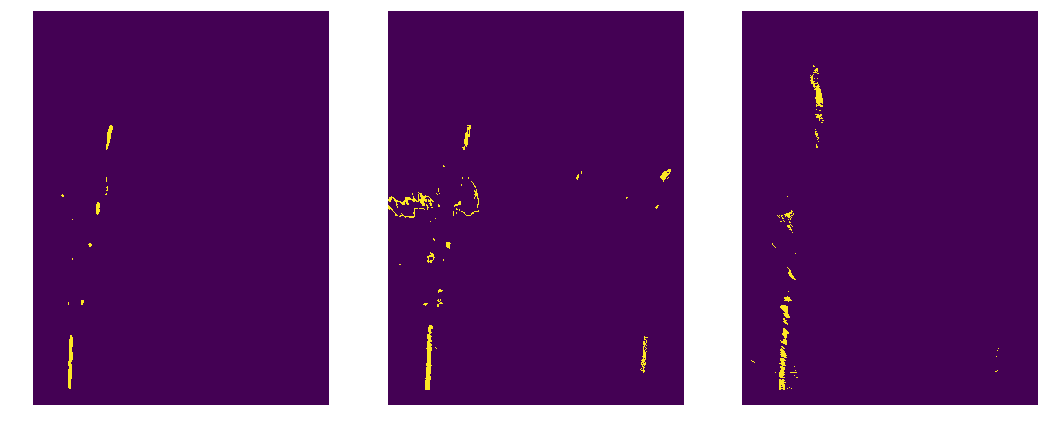

In [10]:
plt.figure(figsize=(18, 8))
for i, im in enumerate( runner['thresholded_images'] ):
    plt.subplot(1, len(runner['thresholded_images']), i+1)
    plt.axis('off')
    plt.imshow(im)
    

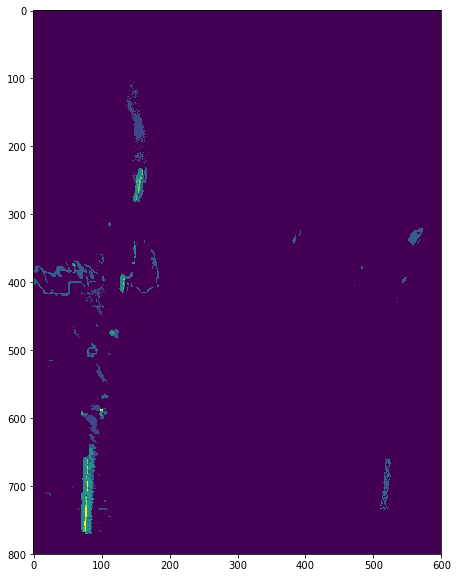

In [11]:
plt.figure(figsize=(8, 10))
plt.imshow(runner['mega_image'])

In [12]:
for num in np.unique(runner['mega_image']):
    num_count = np.sum(runner['mega_image'] == num)
    print('{:d} -> {:d}'.format(num, num_count))

0 -> 472058
5 -> 2202
7 -> 3426
11 -> 1176
12 -> 738
16 -> 121
18 -> 169
23 -> 110


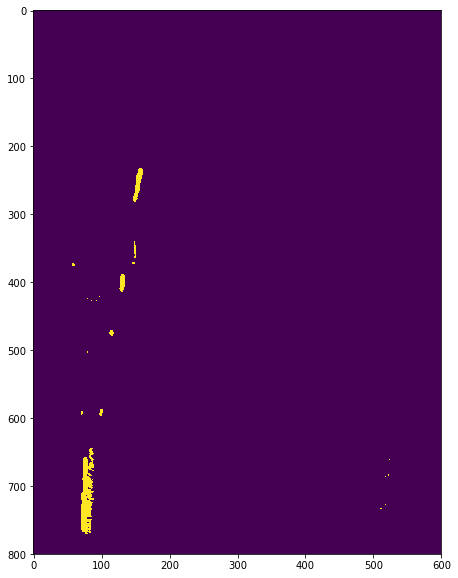

In [13]:
plt.figure(figsize=(8, 10))
plt.imshow( runner['mega_image'] >= 11 )

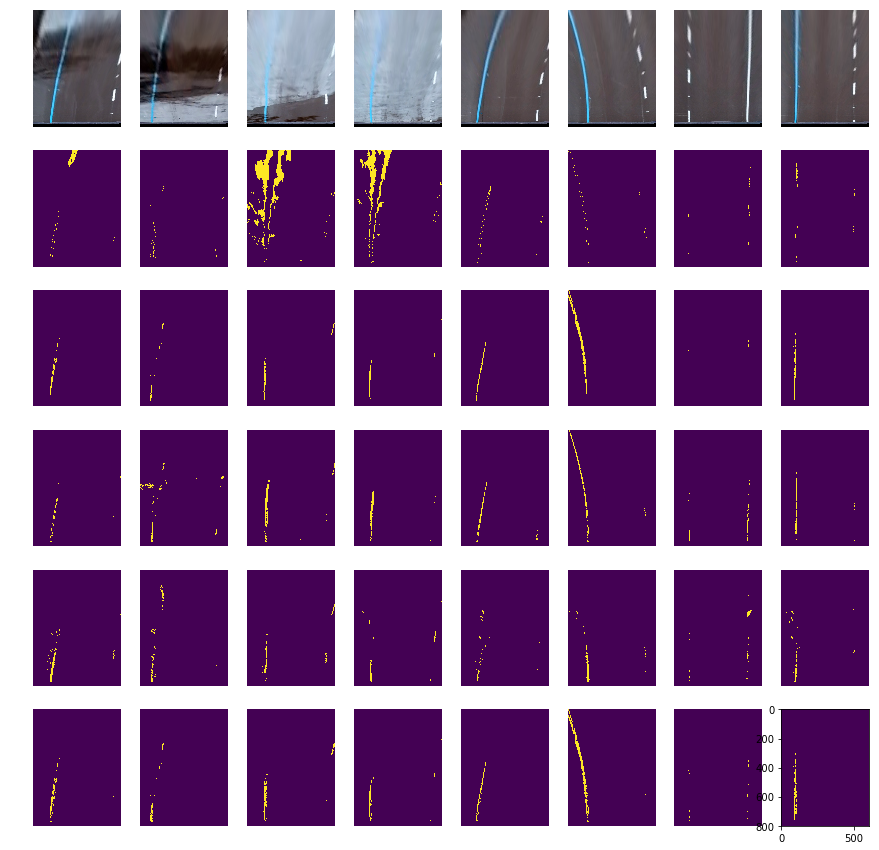

In [14]:
plt.figure(figsize=(15, 15))

for i, im in enumerate(warped_images):
    
    runner.run(image=im)
    
    plt.axis('off')
    plt.subplot(6, 8, i+1)
    plt.imshow( im )
    
    plt.axis('off')
    plt.subplot(6, 8, 8+i+1)
    plt.imshow( runner['thresholded_wHLS'] )
    
    plt.axis('off')
    plt.subplot(6, 8, 16+i+1)
    plt.imshow( runner['tssx_median'] )
    
    plt.axis('off')
    plt.subplot(6, 8, 24+i+1)
    plt.imshow( runner['ts_closed'] )
    
    plt.axis('off')
    plt.subplot(6, 8, 32+i+1)
    plt.imshow( runner['thresholded_H'] )
    
    plt.axis('off')
    plt.subplot(6, 8, 40+i+1)
    plt.imshow( runner['mega_image'] >= 11 )